In [1]:
!pip install transformers bitsandbytes peft
# Downgrading for issue: https://github.com/mahmoodlab/HEST/issues/110
!pip install datasets==2.16.0
!pip install huggingface_hub
!pip install wandb
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 37.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Success

In [176]:
import torch
import cv2
import re
import wandb

from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
from PIL import ImageDraw
from IPython.display import display
import matplotlib.pyplot as plt

from transformers import Trainer
from transformers import TrainingArguments
from transformers import BitsAndBytesConfig
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
from huggingface_hub import snapshot_download
from transformers import logging as hf_logging
import copy
import logging
import time
import functools
import warnings
from google.colab import drive
import json
import os
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics import Accuracy, Recall
import re
from huggingface_hub import notebook_login

from torchvision.ops import box_iou

In [3]:
hf_logging.set_verbosity_error()

In [4]:
# Courtesy to chatgpt
def setup_notebook_logger():
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    if logger.hasHandlers():
        logger.handlers.clear()

    handler = logging.StreamHandler()
    handler.setLevel(logging.INFO)

    formatter = logging.Formatter("[%(asctime)s] [%(levelname)s] %(message)s",
                                  datefmt="%H:%M:%S")
    handler.setFormatter(formatter)

    logger.addHandler(handler)
    return logger

logger = setup_notebook_logger()

# Test
logger.info("Notebook logger is working ✅")

[10:09:50] [INFO] Notebook logger is working ✅


In [212]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [249]:
wandb.init(project="valorant_paligemma2_benchmark", name="finetuned_run")

finetuned_running_iou_class_dropped spike,██▁▁▁▁
finetuned_running_iou_class_enemy,▁▁█▅█▃
finetuned_running_iou_class_planted spike,██▁▁▁▁
finetuned_running_iou_class_teammate,▁▁▁█▁▅
pretrained_running_iou_class_dropped spike,██▇▇▇▆▅▄▄▄▃▂▂▁▁▇▇▆▆▆▅▅▅▅▅▅▄▄▃▄▄▃▃▃▃▂▂▂▂▁
pretrained_running_iou_class_enemy,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁
pretrained_running_iou_class_planted spike,██▇▇▇▆▆▅▆▆▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▁▁▁▁
pretrained_running_iou_class_teammate,█████▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
finetuned_running_iou_class_dropped spike,0
finetuned_running_iou_class_enemy,0.08576
finetuned_running_iou_class_planted spike,0


In [6]:
# hugging face login
notebook_login()
!git config --global credential.helper store

In [7]:
def log_time(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        logger.info(f"{func.__name__}() took {end - start:.2f} seconds")
        return result
    return wrapper

In [8]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
device

device(type='cuda')

In [9]:
# Dataset classes
classes = ['dropped spike', 'enemy', 'planted spike', 'teammate']
labels_map = {
    'dropped spike': 0,
    'enemy': 1,
    'planted spike': 2,
    'teammate': 3,
}

In [10]:
def visualize(example):
  image = example['image']
  category_idx = example['objects']['category'][0]
  display(image)
  category = classes[category_idx]
  print(f"Object Category: {category}")

In [11]:
def coco_to_xyxy(coordinates):
  x, y, width, height = coordinates
  x1, y1 = x, y
  x2 = x1 + width
  y2 = y1 + height
  return [x1, y1, x2, y2]

In [12]:
def paligemma_decoded_format(encoded_bbox):
  """
  This method decodes Paligemma specific format <locXXXX><locXXXX><locXXXX><locXXXX> [CLASS]; <locXXXX><locXXXX><locXXXX><locXXXX> [CLASS] ; ...
  into XYXY format [x1, y1, x2, y2] where each values represnts corner points of bounding box

  Decodes string like "<loc0005><loc0234><loc0450><loc0678> cat"
  into
  [
    {
      'bbox': [5, 234, 450, 678],
      'label': cat
    }
  ]
  """
  pattern = r"<loc(\d{4})><loc(\d{4})><loc(\d{4})><loc(\d{4})>\s+([^;]+)"
  matches = re.findall(pattern, encoded_bbox)
  decoded_strs = []
  for c_match in matches:
    if len(c_match) < 5:
      raise ValueError("Not Enough <locXXXX> tokens found")
    coords = list(map(lambda x: int(x)/1024, c_match[:4]))
    label = c_match[4].strip()
    decoded_strs.append({
        'label': label,
        'bbox': coords
    })

  return decoded_strs

In [14]:
dataset_key = "umairhassan02/paligemma-valorant-object-detection-transformed"
valorant_ds = load_dataset(dataset_key)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6927 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1983 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/988 [00:00<?, ? examples/s]

In [15]:
valorant_ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects', 'paligemma_label'],
        num_rows: 6927
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects', 'paligemma_label'],
        num_rows: 1983
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects', 'paligemma_label'],
        num_rows: 988
    })
})

In [16]:
train_split = valorant_ds['train']
test_split = valorant_ds['test']
valid_split = valorant_ds['validation']
print(f"Train split size: {len(train_split)}")
print(f"Validation split size: {len(valid_split)}")
print(f"Test split size: {len(test_split)}")

Train split size: 6927
Validation split size: 1983
Test split size: 988


In [17]:
# Ref: https://huggingface.co/google/paligemma-3b-pt-242
PRETRAINED_MODEL_ID = "google/paligemma-3b-pt-224"

In [18]:
processor = PaliGemmaProcessor.from_pretrained(PRETRAINED_MODEL_ID)

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [19]:
snapshot_download(repo_id=PRETRAINED_MODEL_ID)

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

'/root/.cache/huggingface/hub/models--google--paligemma-3b-pt-224/snapshots/35e4f46485b4d07967e7e9935bc3786aad50687c'

In [20]:
FINETUNED_MODEL_ID = "umairhassan02/paligemma2_finetuned"

In [21]:
snapshot_download(repo_id=FINETUNED_MODEL_ID)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

adapter_config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.78k [00:00<?, ?B/s]

'/root/.cache/huggingface/hub/models--umairhassan02--paligemma2_finetuned/snapshots/358a1bd28c626c03f70c99909661ea8fd3ca7cf7'

In [22]:
pretrained_model=PaliGemmaForConditionalGeneration.from_pretrained(PRETRAINED_MODEL_ID)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
finetuned_model = PaliGemmaForConditionalGeneration.from_pretrained(FINETUNED_MODEL_ID)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
finetuned_model.to(device)

PaliGemmaForConditionalGeneration(
  (model): PaliGemmaModel(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(256, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1152, out_features=8, bias=False)
                  )
                  (lora_B):

In [25]:
pretrained_model.to(device)

PaliGemmaForConditionalGeneration(
  (model): PaliGemmaModel(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(256, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm2): LayerNorm((1152,), eps=1e-06, elem

In [26]:
next(finetuned_model.parameters()).device

device(type='cuda', index=0)

In [27]:
next(pretrained_model.parameters()).device

device(type='cuda', index=0)

## Running Model Benchmarks

In [28]:
def draw_bboxes(image, bbox_cords, labels):
  img = copy.deepcopy(image)
  draw = ImageDraw.Draw(img)

  # pixel values are normalized in range [0,1]
  # multiple these values by image height and width to get actual pixel coordinates
  W, H = img.size
  for bbox, label in zip(bbox_cords, labels):
    x1, y1, x2, y2 = bbox
    draw.rectangle([x1 * W, y1 * H, x2 * W, y2 * H], width=3)
    draw.text((x1 * W, y1 * H), text=label, fill=(255, 0, 0))
  return img

In [167]:
metric_map = MeanAveragePrecision(
    iou_type="bbox",
    iou_thresholds=[0.3, 0.5, 0.75]  # lenient, standard, strict
)
acc = Accuracy(task="multiclass", num_classes=4)
recall = Recall(task="multiclass", num_classes=4)

In [200]:
# Global accumulators
all_preds_labels = []
all_targets_labels = []
all_pred_boxes = []
all_target_boxes = []

def compute_metrics_accumulate(model_pred, sample):
    """Update global mAP metric and accumulate labels for accuracy/recall"""
    H, W = sample['height'], sample['width']
    scale = torch.tensor([W, H, W, H], dtype=torch.float32)

    # Unnormalize predicted boxes
    model_pred[0]['boxes'] = model_pred[0]['boxes'] * scale

    # Prepare targets
    xyxy_boxes = [coco_to_xyxy(box) for box in sample['objects']['bbox']]
    targets = [{
        'labels': torch.tensor(sample['objects']['category'], dtype=torch.int64),
        'boxes': torch.tensor(xyxy_boxes, dtype=torch.float32)
    }]

    # Move to CPU
    for d in model_pred:
        d['boxes'] = d['boxes'].cpu()
        d['labels'] = d['labels'].cpu()
        d['scores'] = d['scores'].cpu()
    for d in targets:
        d['boxes'] = d['boxes'].cpu()
        d['labels'] = d['labels'].cpu()

    # Update mAP
    metric_map.update(model_pred, targets)

    # Accumulate for accuracy/recall (only if number matches)
    pred_labels = model_pred[0]['labels']
    target_labels = targets[0]['labels']
    pred_boxes = model_pred[0]['boxes']
    target_boxes = targets[0]['boxes']

    min_len = min(len(pred_labels), len(target_labels))
    if min_len > 0:
        all_preds_labels.append(pred_labels[:min_len])
        all_targets_labels.append(target_labels[:min_len])
        all_pred_boxes.append(pred_boxes[:min_len])
        all_target_boxes.append(target_boxes[:min_len])

In [195]:
def average_iou_per_class(all_pred_boxes, all_target_boxes, all_pred_labels, all_target_labels, num_classes):
    class_ious = {c: [] for c in range(num_classes)}

    for pred_boxes, targ_boxes, pred_labels, targ_labels in zip(
            all_pred_boxes, all_target_boxes, all_pred_labels, all_target_labels):
        for c in range(num_classes):
            # get boxes of this class
            pred_c = pred_boxes[pred_labels == c]
            targ_c = targ_boxes[targ_labels == c]

            if len(pred_c) == 0 or len(targ_c) == 0:
                continue

            ious = box_iou(pred_c, targ_c)  # [num_pred, num_target]
            if ious.numel() > 0:
                class_ious[c].append(ious.mean().item())

    # average per class
    return {c: (sum(class_ious[c])/len(class_ious[c]) if class_ious[c] else 0.0) for c in range(num_classes)}

In [188]:
# Inference function
@log_time
def process_image_text(image, text, model):
  inputs = processor(text=text, images=image.convert("RGB"), return_tensors="pt").to(device)
  try:
    output = model.generate(**inputs, max_new_tokens=100)

    decoded_output = processor.decode(output[0], skip_special_tokens=True)
    decoded_strs = paligemma_decoded_format(decoded_output)
    if decoded_strs:
      decoded_bboxes = [d['bbox'] for d in decoded_strs]
      decoded_labels = [d['label'] for d in decoded_strs]
      annotated_image = draw_bboxes(image, decoded_bboxes, decoded_labels)

      # FOR METRICS PLOT
      num_boxes = len(decoded_labels)  # or len(decoded_bboxes), they should be same
      model_pred = [{
          'labels': torch.tensor([labels_map[label] for label in decoded_labels], dtype=torch.int64),
          'boxes': torch.tensor(decoded_bboxes, dtype=torch.float32),
          'scores': torch.tensor([1.0] * num_boxes, dtype=torch.float32)  # match length
      }]

      return annotated_image, model_pred
    else:
      raise Exception("No bounding box detected by model")
  except Exception as e:
    print("Error occured during model inference")
    print(e)
    return image, ""

In [222]:
@log_time
def bulk_inference(model, samples, model_type):
    preds = []

    for sample in samples:
        to_detect = ", ".join(classes[idx] for idx in sample['objects']['category'])
        annotated_image, model_pred = process_image_text(sample['image'], f"detect {to_detect}", model)
        preds.append({'model_output': annotated_image})

        if model_pred:
            compute_metrics_accumulate(model_pred, sample)

    running_avg_ious = average_iou_per_class(
        all_pred_boxes, all_target_boxes,
        all_preds_labels, all_targets_labels,
        num_classes=len(classes)
    )

    # Log to W&B
    wandb.log({f"{model_type}_running_iou_class_{classes[c]}": v for c, v in running_avg_ious.items()})

    return preds

In [43]:
@log_time
def visualize_model_comparisons(test_samples, pretrained_model, finetuned_model, max_samples=5):
    """
    Run model comparison on multiple samples and display results in a grid.

    Args:
        test_samples: list of dicts, each with keys ["image", "paligemma_label"]
        pretrained_model: pretrained model object
        finetuned_model: finetuned model object
        max_samples: number of samples to visualize
    """

    pretrained_preds = bulk_inference(pretrained_model, test_samples, max_samples)
    finetuned_preds = bulk_inference(finetuned_model, test_samples, max_samples)
    assert(len(pretrained_preds) == len(finetuned_preds))

    num_samples = len(pretrained_preds)
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    if num_samples == 1:  # handle single-sample case (axs won't be 2D array)
        axs = [axs]

    for i in range(num_samples):
        sample = test_samples[i]

        # --- Ground truth
        decoded_strs = paligemma_decoded_format(sample['paligemma_label'])
        decoded_bboxes = [d['bbox'] for d in decoded_strs]
        decoded_labels = [d['label'] for d in decoded_strs]
        gt_img = draw_bboxes(sample['image'], decoded_bboxes, decoded_labels)

        # --- Pretrained
        pretrained_img = pretrained_preds[i]['model_output']

        # --- Finetuned
        finetuned_img = finetuned_preds[i]['model_output']

        # --- Plot in grid
        axs[i][0].imshow(gt_img); axs[i][0].set_title(f"Sample {i+1} - Ground Truth")
        axs[i][1].imshow(pretrained_img); axs[i][1].set_title("Pretrained")
        axs[i][2].imshow(finetuned_img); axs[i][2].set_title("Finetuned")

        for j in range(3):
            axs[i][j].axis("off")

    plt.tight_layout()
    plt.show()

[10:13:57] [INFO] STARING BULK INFERENCE FOR BULK SIZE: 5
[10:13:59] [INFO] process_image_text() took 2.09 seconds
[10:14:00] [INFO] process_image_text() took 0.24 seconds
[10:14:00] [INFO] process_image_text() took 0.23 seconds
[10:14:00] [INFO] process_image_text() took 0.23 seconds
[10:14:00] [INFO] process_image_text() took 0.23 seconds
[10:14:00] [INFO] FINISHED BULK INFERENCE FOR BULK SIZE: 5
[10:14:00] [INFO] bulk_inference() took 3.06 seconds
[10:14:00] [INFO] STARING BULK INFERENCE FOR BULK SIZE: 5
[10:14:01] [INFO] process_image_text() took 0.33 seconds
[10:14:01] [INFO] process_image_text() took 0.32 seconds
[10:14:01] [INFO] process_image_text() took 0.32 seconds
[10:14:02] [INFO] process_image_text() took 0.32 seconds
[10:14:02] [INFO] process_image_text() took 0.32 seconds
[10:14:02] [INFO] FINISHED BULK INFERENCE FOR BULK SIZE: 5
[10:14:02] [INFO] bulk_inference() took 1.61 seconds


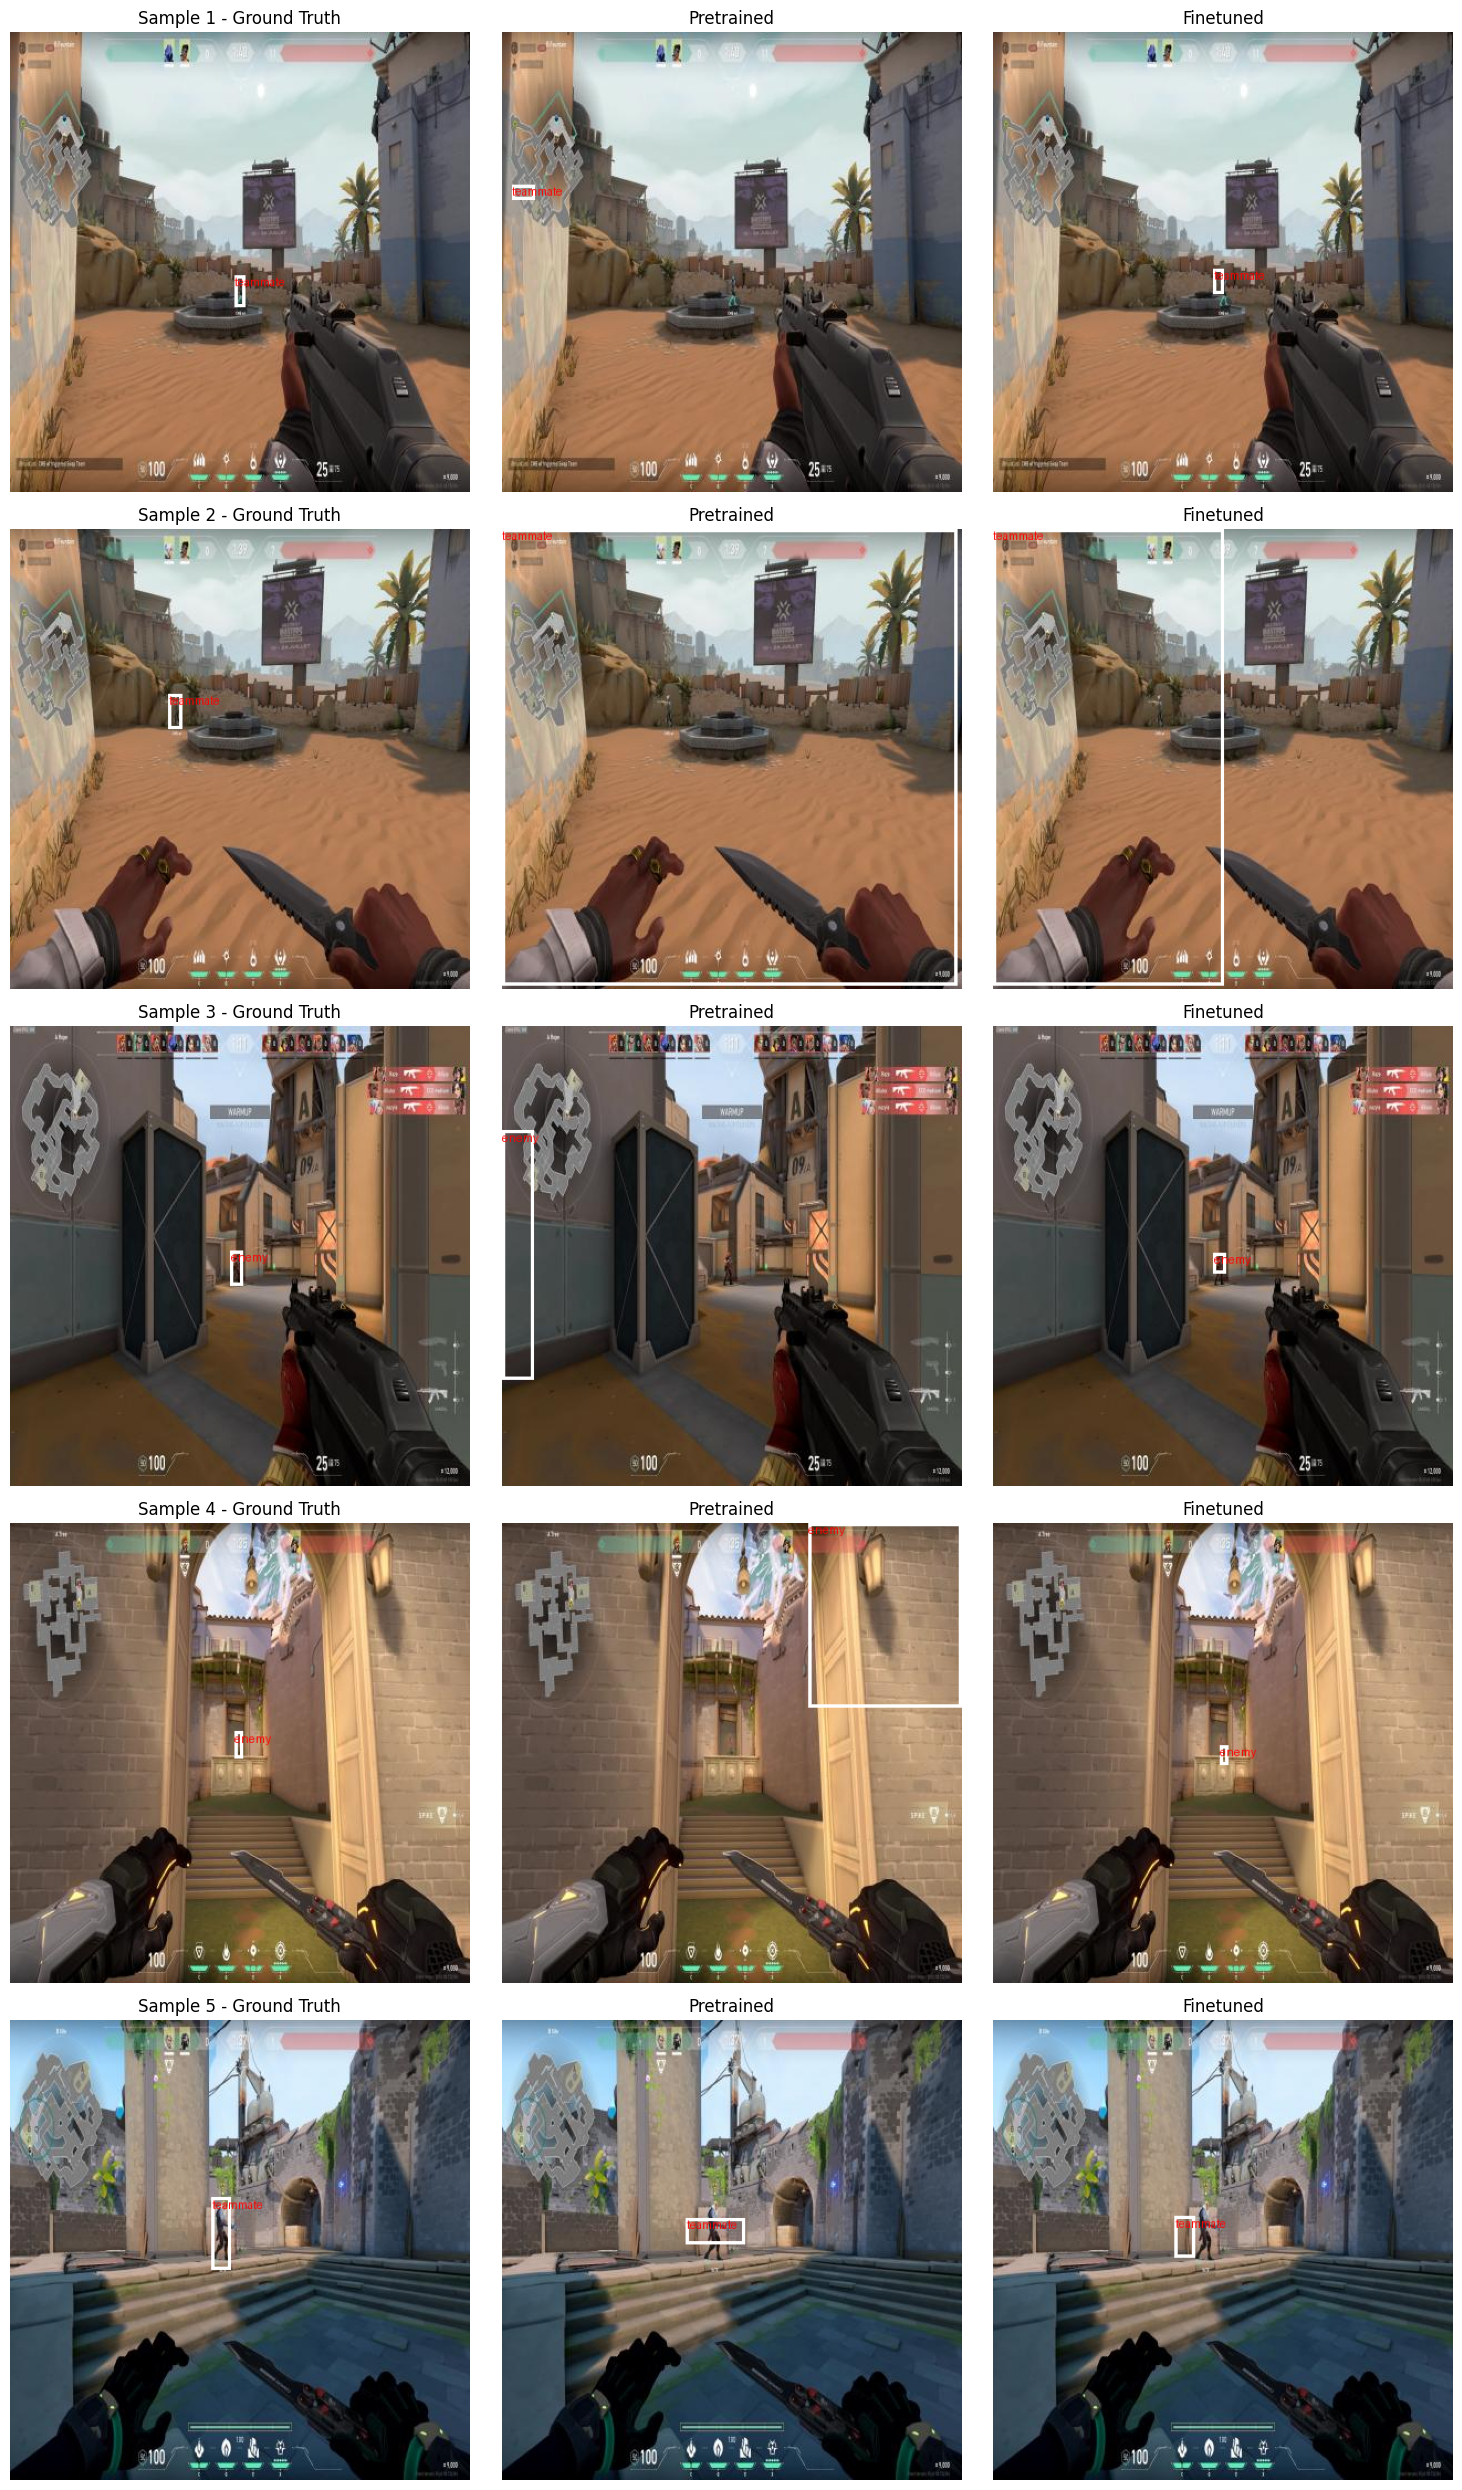

[10:14:04] [INFO] visualize_model_comparisons() took 6.45 seconds


In [36]:
samples = test_split.select(range(5))
visualize_model_comparisons(samples, pretrained_model=pretrained_model, finetuned_model=finetuned_model)

In [246]:
@log_time
def process_bulk_inference_with_checkpoints(model, test_dataset, model_type, batch_size=10):
    dataset_len = len(test_dataset)
    metric_map.reset()
    global all_preds_labels
    global all_pred_boxes
    global all_target_boxes
    global all_targets_labels
    all_preds_labels = []
    all_pred_boxes = []
    all_target_boxes = []
    all_targets_labels = []

    for i in range(0, dataset_len, batch_size):
      from_idx = i
      to_idx = min(i + batch_size, dataset_len)
      logger.info(f"start bulk inference from {from_idx} to {to_idx}")
      samples = test_dataset.select(range(from_idx, to_idx))
      bulk_inference(model, samples, model_type)

    # Compute final metrics after all batches
    final_map = metric_map.compute()

    # Flatten accumulated labels for accuracy/recall
    # Flatten accumulated labels
    pred_flat = torch.cat(all_preds_labels) if all_preds_labels else torch.tensor([], dtype=torch.int64)
    target_flat = torch.cat(all_targets_labels) if all_targets_labels else torch.tensor([], dtype=torch.int64)


    final_acc = acc(pred_flat, target_flat) if len(pred_flat) > 0 else torch.tensor(0.0)
    final_recall = recall(pred_flat, target_flat) if len(pred_flat) > 0 else torch.tensor(0.0)

    logging.info(f"FINAL mAP: {final_map}")
    logging.info(f"FINAL Accuracy: {final_acc}")
    logging.info(f"FINAL Recall: {final_recall}")

    # --- Compute average IoU per class here ---
    avg_ious = average_iou_per_class(all_pred_boxes, all_target_boxes, all_preds_labels, all_targets_labels, num_classes=len(classes))
    logger.info(f"Average IoU per class: {avg_ious}")

    return final_map, final_acc, final_recall

In [250]:
process_bulk_inference_with_checkpoints(finetuned_model, test_split, "finetuned")

[13:33:13] [INFO] start bulk inference from 0 to 10
[13:33:13] [INFO] process_image_text() took 0.34 seconds
[13:33:13] [INFO] process_image_text() took 0.31 seconds
[13:33:14] [INFO] process_image_text() took 0.31 seconds
[13:33:14] [INFO] process_image_text() took 0.32 seconds
[13:33:14] [INFO] process_image_text() took 0.31 seconds
[13:33:15] [INFO] process_image_text() took 0.31 seconds
[13:33:15] [INFO] process_image_text() took 0.32 seconds
[13:33:15] [INFO] process_image_text() took 0.31 seconds
[13:33:16] [INFO] process_image_text() took 0.31 seconds
[13:33:16] [INFO] process_image_text() took 0.31 seconds
[13:33:16] [INFO] bulk_inference() took 3.20 seconds
[13:33:16] [INFO] start bulk inference from 10 to 20
[13:33:16] [INFO] process_image_text() took 0.31 seconds
[13:33:17] [INFO] process_image_text() took 0.32 seconds
[13:33:17] [INFO] process_image_text() took 0.31 seconds
[13:33:17] [INFO] process_image_text() took 0.31 seconds
[13:33:18] [INFO] process_image_text() took 

Error occured during model inference
No bounding box detected by model


[13:35:08] [INFO] process_image_text() took 0.31 seconds
[13:35:08] [INFO] process_image_text() took 0.31 seconds
[13:35:09] [INFO] process_image_text() took 0.31 seconds
[13:35:09] [INFO] process_image_text() took 0.31 seconds
[13:35:09] [INFO] process_image_text() took 0.31 seconds
[13:35:10] [INFO] process_image_text() took 0.32 seconds
[13:35:10] [INFO] process_image_text() took 0.31 seconds
[13:35:10] [INFO] process_image_text() took 0.31 seconds
[13:35:10] [INFO] bulk_inference() took 3.07 seconds
[13:35:10] [INFO] start bulk inference from 350 to 360
[13:35:11] [INFO] process_image_text() took 0.32 seconds
[13:35:11] [INFO] process_image_text() took 0.31 seconds
[13:35:11] [INFO] process_image_text() took 0.31 seconds
[13:35:12] [INFO] process_image_text() took 0.31 seconds
[13:35:12] [INFO] process_image_text() took 0.62 seconds
[13:35:13] [INFO] process_image_text() took 0.61 seconds
[13:35:13] [INFO] process_image_text() took 0.31 seconds
[13:35:13] [INFO] process_image_text(

({'map': tensor(0.0070),
  'map_50': tensor(0.0070),
  'map_75': tensor(1.7555e-05),
  'map_small': tensor(0.0085),
  'map_medium': tensor(0.0055),
  'map_large': tensor(0.),
  'mar_1': tensor(0.0298),
  'mar_10': tensor(0.0298),
  'mar_100': tensor(0.0298),
  'mar_small': tensor(0.0390),
  'mar_medium': tensor(0.0084),
  'mar_large': tensor(0.),
  'map_per_class': tensor(-1.),
  'mar_100_per_class': tensor(-1.),
  'classes': tensor([0, 1, 2, 3], dtype=torch.int32)},
 tensor(0.9961),
 tensor(0.9961))

In [251]:
wandb.finish()

finetuned_running_iou_class_dropped spike,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▄▃▃▃▃▃▃▃▃▅▆▆████▇▇▇▇▇
finetuned_running_iou_class_enemy,█▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
finetuned_running_iou_class_planted spike,▇▅██▇▅▅▅▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁
finetuned_running_iou_class_teammate,▃▁▄▆▆▇█▆▅▅▅▆▆▇██▇████▇▇▇▇▇▇▇▇▇█▇▇██▇▇▇▇▇
finetuned_running_iou_class_dropped spike,0.00463
finetuned_running_iou_class_enemy,0.05705
finetuned_running_iou_class_planted spike,0.0859
finetuned_running_iou_class_teammate,0.09714


In [252]:
wandb.init(project="valorant_paligemma2_benchmark", name="pretrained_run")

In [253]:
process_bulk_inference_with_checkpoints(pretrained_model, test_split, "pretrained")

[13:39:03] [INFO] start bulk inference from 0 to 10
[13:39:03] [INFO] process_image_text() took 0.25 seconds
[13:39:04] [INFO] process_image_text() took 0.23 seconds
[13:39:04] [INFO] process_image_text() took 0.23 seconds
[13:39:04] [INFO] process_image_text() took 0.23 seconds
[13:39:04] [INFO] process_image_text() took 0.22 seconds
[13:39:05] [INFO] process_image_text() took 0.23 seconds
[13:39:05] [INFO] process_image_text() took 0.23 seconds
[13:39:05] [INFO] process_image_text() took 0.23 seconds
[13:39:05] [INFO] process_image_text() took 0.23 seconds
[13:39:05] [INFO] process_image_text() took 0.23 seconds
[13:39:05] [INFO] bulk_inference() took 2.32 seconds
[13:39:05] [INFO] start bulk inference from 10 to 20
[13:39:06] [INFO] process_image_text() took 0.23 seconds
[13:39:06] [INFO] process_image_text() took 0.23 seconds
[13:39:06] [INFO] process_image_text() took 0.23 seconds
[13:39:06] [INFO] process_image_text() took 0.23 seconds
[13:39:07] [INFO] process_image_text() took 

Error occured during model inference
'planted spike, enemy'


[13:39:16] [INFO] process_image_text() took 0.22 seconds
[13:39:16] [INFO] process_image_text() took 0.23 seconds
[13:39:16] [INFO] process_image_text() took 0.23 seconds
[13:39:16] [INFO] process_image_text() took 0.23 seconds
[13:39:17] [INFO] process_image_text() took 0.22 seconds
[13:39:17] [INFO] process_image_text() took 0.22 seconds
[13:39:17] [INFO] process_image_text() took 0.22 seconds
[13:39:17] [INFO] bulk_inference() took 2.39 seconds
[13:39:17] [INFO] start bulk inference from 60 to 70
[13:39:17] [INFO] process_image_text() took 0.23 seconds
[13:39:18] [INFO] process_image_text() took 0.22 seconds
[13:39:18] [INFO] process_image_text() took 0.23 seconds
[13:39:18] [INFO] process_image_text() took 0.22 seconds
[13:39:18] [INFO] process_image_text() took 0.22 seconds
[13:39:19] [INFO] process_image_text() took 0.22 seconds
[13:39:19] [INFO] process_image_text() took 0.23 seconds
[13:39:19] [INFO] process_image_text() took 0.22 seconds
[13:39:19] [INFO] process_image_text() 

Error occured during model inference
'dropped spike, teammate'


[13:39:36] [INFO] process_image_text() took 0.25 seconds
[13:39:36] [INFO] bulk_inference() took 2.48 seconds
[13:39:36] [INFO] start bulk inference from 140 to 150
[13:39:36] [INFO] process_image_text() took 0.22 seconds
[13:39:36] [INFO] process_image_text() took 0.23 seconds
[13:39:37] [INFO] process_image_text() took 0.22 seconds
[13:39:37] [INFO] process_image_text() took 0.22 seconds
[13:39:37] [INFO] process_image_text() took 0.22 seconds
[13:39:37] [INFO] process_image_text() took 0.22 seconds
[13:39:38] [INFO] process_image_text() took 0.22 seconds
[13:39:38] [INFO] process_image_text() took 0.22 seconds
[13:39:38] [INFO] process_image_text() took 0.22 seconds
[13:39:38] [INFO] process_image_text() took 0.22 seconds
[13:39:38] [INFO] bulk_inference() took 2.31 seconds
[13:39:38] [INFO] start bulk inference from 150 to 160
[13:39:39] [INFO] process_image_text() took 0.22 seconds
[13:39:39] [INFO] process_image_text() took 0.23 seconds
[13:39:39] [INFO] process_image_text() took

Error occured during model inference
'planted spike, enemy'


[13:39:42] [INFO] process_image_text() took 0.23 seconds
[13:39:43] [INFO] process_image_text() took 0.23 seconds
[13:39:43] [INFO] process_image_text() took 0.25 seconds
[13:39:43] [INFO] process_image_text() took 0.25 seconds
[13:39:43] [INFO] bulk_inference() took 2.48 seconds
[13:39:43] [INFO] start bulk inference from 170 to 180
[13:39:43] [INFO] process_image_text() took 0.22 seconds
[13:39:44] [INFO] process_image_text() took 0.23 seconds
[13:39:44] [INFO] process_image_text() took 0.22 seconds
[13:39:44] [INFO] process_image_text() took 0.23 seconds
[13:39:44] [INFO] process_image_text() took 0.25 seconds
[13:39:45] [INFO] process_image_text() took 0.24 seconds
[13:39:45] [INFO] process_image_text() took 0.22 seconds
[13:39:45] [INFO] process_image_text() took 0.23 seconds
[13:39:45] [INFO] process_image_text() took 0.22 seconds
[13:39:46] [INFO] process_image_text() took 0.23 seconds
[13:39:46] [INFO] bulk_inference() took 2.36 seconds
[13:39:46] [INFO] start bulk inference fr

Error occured during model inference
'dropped spike, teammate'


[13:39:54] [INFO] process_image_text() took 0.23 seconds
[13:39:54] [INFO] process_image_text() took 0.22 seconds
[13:39:54] [INFO] process_image_text() took 0.22 seconds
[13:39:55] [INFO] process_image_text() took 0.23 seconds
[13:39:55] [INFO] process_image_text() took 0.22 seconds
[13:39:55] [INFO] process_image_text() took 0.22 seconds
[13:39:55] [INFO] bulk_inference() took 2.44 seconds
[13:39:55] [INFO] start bulk inference from 220 to 230
[13:39:55] [INFO] process_image_text() took 0.23 seconds
[13:39:56] [INFO] process_image_text() took 0.23 seconds
[13:39:56] [INFO] process_image_text() took 0.25 seconds
[13:39:56] [INFO] process_image_text() took 0.23 seconds
[13:39:56] [INFO] process_image_text() took 0.22 seconds
[13:39:57] [INFO] process_image_text() took 0.24 seconds
[13:39:57] [INFO] process_image_text() took 0.23 seconds
[13:39:57] [INFO] process_image_text() took 0.23 seconds
[13:39:57] [INFO] process_image_text() took 0.22 seconds
[13:39:57] [INFO] process_image_text(

Error occured during model inference
'dropped spike, teammate'


[13:40:04] [INFO] process_image_text() took 0.23 seconds
[13:40:04] [INFO] process_image_text() took 0.22 seconds
[13:40:05] [INFO] process_image_text() took 0.22 seconds
[13:40:05] [INFO] process_image_text() took 0.23 seconds
[13:40:05] [INFO] bulk_inference() took 2.46 seconds
[13:40:05] [INFO] start bulk inference from 260 to 270
[13:40:05] [INFO] process_image_text() took 0.23 seconds
[13:40:05] [INFO] process_image_text() took 0.23 seconds
[13:40:06] [INFO] process_image_text() took 0.23 seconds
[13:40:06] [INFO] process_image_text() took 0.28 seconds


Error occured during model inference
'enemy, enemy'


[13:40:06] [INFO] process_image_text() took 0.23 seconds
[13:40:06] [INFO] process_image_text() took 0.22 seconds
[13:40:06] [INFO] process_image_text() took 0.22 seconds
[13:40:07] [INFO] process_image_text() took 0.22 seconds
[13:40:07] [INFO] process_image_text() took 0.22 seconds
[13:40:07] [INFO] process_image_text() took 0.22 seconds
[13:40:07] [INFO] bulk_inference() took 2.41 seconds
[13:40:07] [INFO] start bulk inference from 270 to 280
[13:40:08] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'enemy, enemy'


[13:40:08] [INFO] process_image_text() took 0.23 seconds
[13:40:08] [INFO] process_image_text() took 0.23 seconds
[13:40:08] [INFO] process_image_text() took 0.23 seconds
[13:40:08] [INFO] process_image_text() took 0.23 seconds
[13:40:09] [INFO] process_image_text() took 0.30 seconds


Error occured during model inference
'planted spike, enemy'


[13:40:09] [INFO] process_image_text() took 0.23 seconds
[13:40:09] [INFO] process_image_text() took 0.23 seconds
[13:40:09] [INFO] process_image_text() took 0.22 seconds
[13:40:10] [INFO] process_image_text() took 0.23 seconds
[13:40:10] [INFO] bulk_inference() took 2.51 seconds
[13:40:10] [INFO] start bulk inference from 280 to 290
[13:40:10] [INFO] process_image_text() took 0.23 seconds
[13:40:10] [INFO] process_image_text() took 0.25 seconds
[13:40:10] [INFO] process_image_text() took 0.23 seconds
[13:40:11] [INFO] process_image_text() took 0.23 seconds
[13:40:11] [INFO] process_image_text() took 0.22 seconds
[13:40:11] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'planted spike, enemy'


[13:40:11] [INFO] process_image_text() took 0.22 seconds
[13:40:12] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'planted spike, enemy'


[13:40:12] [INFO] process_image_text() took 0.25 seconds
[13:40:12] [INFO] process_image_text() took 0.23 seconds
[13:40:12] [INFO] bulk_inference() took 2.54 seconds
[13:40:12] [INFO] start bulk inference from 290 to 300
[13:40:13] [INFO] process_image_text() took 0.23 seconds
[13:40:13] [INFO] process_image_text() took 0.25 seconds
[13:40:13] [INFO] process_image_text() took 0.22 seconds
[13:40:13] [INFO] process_image_text() took 0.25 seconds
[13:40:14] [INFO] process_image_text() took 0.25 seconds
[13:40:14] [INFO] process_image_text() took 0.23 seconds
[13:40:14] [INFO] process_image_text() took 0.22 seconds
[13:40:14] [INFO] process_image_text() took 0.25 seconds
[13:40:14] [INFO] process_image_text() took 0.22 seconds
[13:40:15] [INFO] process_image_text() took 0.23 seconds
[13:40:15] [INFO] bulk_inference() took 2.46 seconds
[13:40:15] [INFO] start bulk inference from 300 to 310
[13:40:15] [INFO] process_image_text() took 0.22 seconds
[13:40:15] [INFO] process_image_text() took

Error occured during model inference
'dropped spike, teammate'


[13:40:22] [INFO] process_image_text() took 0.23 seconds
[13:40:23] [INFO] process_image_text() took 0.23 seconds
[13:40:23] [INFO] process_image_text() took 0.23 seconds
[13:40:23] [INFO] process_image_text() took 0.23 seconds
[13:40:23] [INFO] process_image_text() took 0.22 seconds
[13:40:23] [INFO] process_image_text() took 0.22 seconds
[13:40:24] [INFO] process_image_text() took 0.22 seconds
[13:40:24] [INFO] process_image_text() took 0.22 seconds
[13:40:24] [INFO] process_image_text() took 0.23 seconds
[13:40:24] [INFO] process_image_text() took 0.25 seconds
[13:40:25] [INFO] bulk_inference() took 2.41 seconds
[13:40:25] [INFO] start bulk inference from 340 to 350
[13:40:25] [INFO] process_image_text() took 0.23 seconds
[13:40:25] [INFO] process_image_text() took 0.11 seconds


Error occured during model inference
No bounding box detected by model


[13:40:25] [INFO] process_image_text() took 0.22 seconds
[13:40:25] [INFO] process_image_text() took 0.22 seconds
[13:40:26] [INFO] process_image_text() took 0.22 seconds
[13:40:26] [INFO] process_image_text() took 0.23 seconds
[13:40:26] [INFO] process_image_text() took 0.22 seconds
[13:40:26] [INFO] process_image_text() took 0.22 seconds
[13:40:26] [INFO] process_image_text() took 0.22 seconds
[13:40:27] [INFO] process_image_text() took 0.23 seconds
[13:40:27] [INFO] bulk_inference() took 2.27 seconds
[13:40:27] [INFO] start bulk inference from 350 to 360
[13:40:27] [INFO] process_image_text() took 0.22 seconds
[13:40:27] [INFO] process_image_text() took 0.23 seconds
[13:40:27] [INFO] process_image_text() took 0.22 seconds
[13:40:28] [INFO] process_image_text() took 0.23 seconds
[13:40:28] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'dropped spike, teammate'


[13:40:28] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'dropped spike, teammate'


[13:40:29] [INFO] process_image_text() took 0.23 seconds
[13:40:29] [INFO] process_image_text() took 0.22 seconds
[13:40:29] [INFO] process_image_text() took 0.22 seconds
[13:40:29] [INFO] process_image_text() took 0.22 seconds
[13:40:29] [INFO] bulk_inference() took 2.52 seconds
[13:40:29] [INFO] start bulk inference from 360 to 370
[13:40:30] [INFO] process_image_text() took 0.22 seconds
[13:40:30] [INFO] process_image_text() took 0.24 seconds
[13:40:30] [INFO] process_image_text() took 0.23 seconds
[13:40:30] [INFO] process_image_text() took 0.11 seconds


Error occured during model inference
No bounding box detected by model


[13:40:30] [INFO] process_image_text() took 0.22 seconds
[13:40:31] [INFO] process_image_text() took 0.22 seconds
[13:40:31] [INFO] process_image_text() took 0.22 seconds
[13:40:31] [INFO] process_image_text() took 0.22 seconds
[13:40:31] [INFO] process_image_text() took 0.22 seconds
[13:40:31] [INFO] process_image_text() took 0.22 seconds
[13:40:32] [INFO] bulk_inference() took 2.30 seconds
[13:40:32] [INFO] start bulk inference from 370 to 380
[13:40:32] [INFO] process_image_text() took 0.23 seconds
[13:40:32] [INFO] process_image_text() took 0.25 seconds
[13:40:32] [INFO] process_image_text() took 0.23 seconds
[13:40:33] [INFO] process_image_text() took 0.22 seconds
[13:40:33] [INFO] process_image_text() took 0.23 seconds
[13:40:33] [INFO] process_image_text() took 0.22 seconds
[13:40:33] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'dropped spike, teammate'


[13:40:34] [INFO] process_image_text() took 0.23 seconds
[13:40:34] [INFO] process_image_text() took 0.24 seconds
[13:40:34] [INFO] process_image_text() took 0.23 seconds
[13:40:34] [INFO] bulk_inference() took 2.49 seconds
[13:40:34] [INFO] start bulk inference from 380 to 390
[13:40:34] [INFO] process_image_text() took 0.23 seconds
[13:40:35] [INFO] process_image_text() took 0.22 seconds
[13:40:35] [INFO] process_image_text() took 0.22 seconds
[13:40:35] [INFO] process_image_text() took 0.22 seconds
[13:40:35] [INFO] process_image_text() took 0.22 seconds
[13:40:35] [INFO] process_image_text() took 0.22 seconds
[13:40:36] [INFO] process_image_text() took 0.23 seconds
[13:40:36] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'planted spike, enemy'


[13:40:36] [INFO] process_image_text() took 0.22 seconds
[13:40:37] [INFO] process_image_text() took 0.29 seconds
[13:40:37] [INFO] bulk_inference() took 2.52 seconds
[13:40:37] [INFO] start bulk inference from 390 to 400


Error occured during model inference
'planted spike, enemy'


[13:40:37] [INFO] process_image_text() took 0.23 seconds
[13:40:37] [INFO] process_image_text() took 0.22 seconds
[13:40:37] [INFO] process_image_text() took 0.22 seconds
[13:40:38] [INFO] process_image_text() took 0.23 seconds
[13:40:38] [INFO] process_image_text() took 0.23 seconds
[13:40:38] [INFO] process_image_text() took 0.22 seconds
[13:40:38] [INFO] process_image_text() took 0.22 seconds
[13:40:38] [INFO] process_image_text() took 0.25 seconds
[13:40:39] [INFO] process_image_text() took 0.23 seconds
[13:40:39] [INFO] process_image_text() took 0.25 seconds
[13:40:39] [INFO] bulk_inference() took 2.44 seconds
[13:40:39] [INFO] start bulk inference from 400 to 410
[13:40:39] [INFO] process_image_text() took 0.23 seconds
[13:40:40] [INFO] process_image_text() took 0.23 seconds
[13:40:40] [INFO] process_image_text() took 0.22 seconds
[13:40:40] [INFO] process_image_text() took 0.22 seconds
[13:40:40] [INFO] process_image_text() took 0.22 seconds
[13:40:40] [INFO] process_image_text(

Error occured during model inference
'dropped spike, teammate'


[13:40:45] [INFO] process_image_text() took 0.23 seconds
[13:40:45] [INFO] process_image_text() took 0.22 seconds
[13:40:45] [INFO] process_image_text() took 0.25 seconds
[13:40:45] [INFO] process_image_text() took 0.23 seconds
[13:40:46] [INFO] process_image_text() took 0.26 seconds
[13:40:46] [INFO] process_image_text() took 0.23 seconds
[13:40:46] [INFO] process_image_text() took 0.22 seconds
[13:40:46] [INFO] process_image_text() took 0.22 seconds
[13:40:46] [INFO] bulk_inference() took 2.56 seconds
[13:40:46] [INFO] start bulk inference from 430 to 440
[13:40:47] [INFO] process_image_text() took 0.22 seconds
[13:40:47] [INFO] process_image_text() took 0.22 seconds
[13:40:47] [INFO] process_image_text() took 0.25 seconds
[13:40:47] [INFO] process_image_text() took 0.22 seconds
[13:40:48] [INFO] process_image_text() took 0.23 seconds
[13:40:48] [INFO] process_image_text() took 0.26 seconds
[13:40:48] [INFO] process_image_text() took 0.22 seconds
[13:40:48] [INFO] process_image_text(

Error occured during model inference
'planted spike, enemy'


[13:40:50] [INFO] process_image_text() took 0.22 seconds
[13:40:50] [INFO] process_image_text() took 0.22 seconds
[13:40:50] [INFO] process_image_text() took 0.22 seconds
[13:40:51] [INFO] process_image_text() took 0.23 seconds
[13:40:51] [INFO] process_image_text() took 0.23 seconds
[13:40:51] [INFO] process_image_text() took 0.22 seconds
[13:40:51] [INFO] process_image_text() took 0.22 seconds
[13:40:51] [INFO] bulk_inference() took 2.47 seconds
[13:40:51] [INFO] start bulk inference from 450 to 460
[13:40:52] [INFO] process_image_text() took 0.22 seconds
[13:40:52] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'dropped spike, teammate'


[13:40:52] [INFO] process_image_text() took 0.23 seconds
[13:40:52] [INFO] process_image_text() took 0.22 seconds
[13:40:53] [INFO] process_image_text() took 0.24 seconds
[13:40:53] [INFO] process_image_text() took 0.22 seconds
[13:40:53] [INFO] process_image_text() took 0.23 seconds
[13:40:53] [INFO] process_image_text() took 0.22 seconds
[13:40:54] [INFO] process_image_text() took 0.23 seconds
[13:40:54] [INFO] process_image_text() took 0.23 seconds
[13:40:54] [INFO] bulk_inference() took 2.50 seconds
[13:40:54] [INFO] start bulk inference from 460 to 470
[13:40:54] [INFO] process_image_text() took 0.23 seconds
[13:40:54] [INFO] process_image_text() took 0.22 seconds
[13:40:55] [INFO] process_image_text() took 0.22 seconds
[13:40:55] [INFO] process_image_text() took 0.25 seconds
[13:40:55] [INFO] process_image_text() took 0.23 seconds
[13:40:55] [INFO] process_image_text() took 0.22 seconds
[13:40:56] [INFO] process_image_text() took 0.23 seconds
[13:40:56] [INFO] process_image_text(

Error occured during model inference
'enemy, enemy'


[13:41:10] [INFO] process_image_text() took 0.22 seconds
[13:41:10] [INFO] process_image_text() took 0.23 seconds
[13:41:11] [INFO] process_image_text() took 0.23 seconds
[13:41:11] [INFO] process_image_text() took 0.22 seconds
[13:41:11] [INFO] process_image_text() took 0.22 seconds
[13:41:11] [INFO] bulk_inference() took 2.53 seconds
[13:41:11] [INFO] start bulk inference from 530 to 540
[13:41:11] [INFO] process_image_text() took 0.23 seconds
[13:41:12] [INFO] process_image_text() took 0.23 seconds
[13:41:12] [INFO] process_image_text() took 0.25 seconds
[13:41:12] [INFO] process_image_text() took 0.23 seconds
[13:41:12] [INFO] process_image_text() took 0.22 seconds
[13:41:13] [INFO] process_image_text() took 0.23 seconds
[13:41:13] [INFO] process_image_text() took 0.22 seconds
[13:41:13] [INFO] process_image_text() took 0.22 seconds
[13:41:13] [INFO] process_image_text() took 0.22 seconds
[13:41:13] [INFO] process_image_text() took 0.22 seconds
[13:41:14] [INFO] bulk_inference() to

Error occured during model inference
'dropped spike, teammate'


[13:41:14] [INFO] process_image_text() took 0.22 seconds
[13:41:14] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'dropped spike, teammate'


[13:41:15] [INFO] process_image_text() took 0.23 seconds
[13:41:15] [INFO] process_image_text() took 0.22 seconds
[13:41:15] [INFO] process_image_text() took 0.22 seconds
[13:41:15] [INFO] process_image_text() took 0.22 seconds
[13:41:16] [INFO] process_image_text() took 0.23 seconds
[13:41:16] [INFO] process_image_text() took 0.23 seconds
[13:41:16] [INFO] process_image_text() took 0.22 seconds
[13:41:16] [INFO] bulk_inference() took 2.57 seconds
[13:41:16] [INFO] start bulk inference from 550 to 560
[13:41:16] [INFO] process_image_text() took 0.23 seconds
[13:41:17] [INFO] process_image_text() took 0.23 seconds
[13:41:17] [INFO] process_image_text() took 0.22 seconds
[13:41:17] [INFO] process_image_text() took 0.25 seconds
[13:41:17] [INFO] process_image_text() took 0.22 seconds
[13:41:18] [INFO] process_image_text() took 0.22 seconds
[13:41:18] [INFO] process_image_text() took 0.23 seconds
[13:41:18] [INFO] process_image_text() took 0.23 seconds
[13:41:18] [INFO] process_image_text(

Error occured during model inference
'planted spike, enemy'


[13:41:21] [INFO] process_image_text() took 0.23 seconds
[13:41:21] [INFO] bulk_inference() took 2.58 seconds
[13:41:21] [INFO] start bulk inference from 570 to 580
[13:41:22] [INFO] process_image_text() took 0.23 seconds
[13:41:22] [INFO] process_image_text() took 0.28 seconds


Error occured during model inference
'enemy, enemy'


[13:41:22] [INFO] process_image_text() took 0.23 seconds
[13:41:22] [INFO] process_image_text() took 0.22 seconds
[13:41:23] [INFO] process_image_text() took 0.22 seconds
[13:41:23] [INFO] process_image_text() took 0.23 seconds
[13:41:23] [INFO] process_image_text() took 0.22 seconds
[13:41:23] [INFO] process_image_text() took 0.27 seconds


Error occured during model inference
'enemy, enemy'


[13:41:23] [INFO] process_image_text() took 0.22 seconds
[13:41:24] [INFO] process_image_text() took 0.23 seconds
[13:41:24] [INFO] bulk_inference() took 2.56 seconds
[13:41:24] [INFO] start bulk inference from 580 to 590
[13:41:24] [INFO] process_image_text() took 0.23 seconds
[13:41:24] [INFO] process_image_text() took 0.22 seconds
[13:41:25] [INFO] process_image_text() took 0.22 seconds
[13:41:25] [INFO] process_image_text() took 0.22 seconds
[13:41:25] [INFO] process_image_text() took 0.22 seconds
[13:41:25] [INFO] process_image_text() took 0.22 seconds
[13:41:25] [INFO] process_image_text() took 0.23 seconds
[13:41:26] [INFO] process_image_text() took 0.22 seconds
[13:41:26] [INFO] process_image_text() took 0.22 seconds
[13:41:26] [INFO] process_image_text() took 0.22 seconds
[13:41:26] [INFO] bulk_inference() took 2.44 seconds
[13:41:26] [INFO] start bulk inference from 590 to 600
[13:41:27] [INFO] process_image_text() took 0.22 seconds
[13:41:27] [INFO] process_image_text() took

Error occured during model inference
'enemy, planted spike'


[13:41:34] [INFO] process_image_text() took 0.22 seconds
[13:41:35] [INFO] process_image_text() took 0.23 seconds
[13:41:35] [INFO] process_image_text() took 0.22 seconds
[13:41:35] [INFO] process_image_text() took 0.22 seconds
[13:41:35] [INFO] process_image_text() took 0.22 seconds
[13:41:35] [INFO] process_image_text() took 0.22 seconds
[13:41:36] [INFO] process_image_text() took 0.22 seconds
[13:41:36] [INFO] process_image_text() took 0.22 seconds
[13:41:36] [INFO] process_image_text() took 0.23 seconds
[13:41:36] [INFO] bulk_inference() took 2.53 seconds
[13:41:36] [INFO] start bulk inference from 630 to 640
[13:41:37] [INFO] process_image_text() took 0.23 seconds
[13:41:37] [INFO] process_image_text() took 0.22 seconds
[13:41:37] [INFO] process_image_text() took 0.22 seconds
[13:41:37] [INFO] process_image_text() took 0.23 seconds
[13:41:38] [INFO] process_image_text() took 0.25 seconds
[13:41:38] [INFO] process_image_text() took 0.23 seconds
[13:41:38] [INFO] process_image_text(

Error occured during model inference
'enemy, planted spike'


[13:42:00] [INFO] process_image_text() took 0.23 seconds
[13:42:00] [INFO] process_image_text() took 0.23 seconds
[13:42:00] [INFO] process_image_text() took 0.25 seconds
[13:42:00] [INFO] process_image_text() took 0.23 seconds
[13:42:01] [INFO] process_image_text() took 0.23 seconds
[13:42:01] [INFO] process_image_text() took 0.23 seconds
[13:42:01] [INFO] process_image_text() took 0.23 seconds
[13:42:01] [INFO] process_image_text() took 0.23 seconds
[13:42:01] [INFO] bulk_inference() took 2.59 seconds
[13:42:01] [INFO] start bulk inference from 730 to 740
[13:42:02] [INFO] process_image_text() took 0.23 seconds
[13:42:02] [INFO] process_image_text() took 0.23 seconds
[13:42:02] [INFO] process_image_text() took 0.22 seconds
[13:42:02] [INFO] process_image_text() took 0.23 seconds
[13:42:03] [INFO] process_image_text() took 0.23 seconds
[13:42:03] [INFO] process_image_text() took 0.23 seconds
[13:42:03] [INFO] process_image_text() took 0.22 seconds
[13:42:03] [INFO] process_image_text(

Error occured during model inference
'dropped spike, teammate'


[13:42:06] [INFO] process_image_text() took 0.23 seconds
[13:42:06] [INFO] process_image_text() took 0.23 seconds
[13:42:06] [INFO] process_image_text() took 0.23 seconds
[13:42:06] [INFO] process_image_text() took 0.25 seconds
[13:42:07] [INFO] bulk_inference() took 2.59 seconds
[13:42:07] [INFO] start bulk inference from 750 to 760
[13:42:07] [INFO] process_image_text() took 0.23 seconds
[13:42:07] [INFO] process_image_text() took 0.23 seconds
[13:42:07] [INFO] process_image_text() took 0.22 seconds
[13:42:08] [INFO] process_image_text() took 0.23 seconds
[13:42:08] [INFO] process_image_text() took 0.23 seconds
[13:42:08] [INFO] process_image_text() took 0.23 seconds
[13:42:08] [INFO] process_image_text() took 0.23 seconds
[13:42:08] [INFO] process_image_text() took 0.23 seconds
[13:42:09] [INFO] process_image_text() took 0.23 seconds
[13:42:09] [INFO] process_image_text() took 0.23 seconds
[13:42:09] [INFO] bulk_inference() took 2.53 seconds
[13:42:09] [INFO] start bulk inference fr

Error occured during model inference
'planted spike, enemy'


[13:42:10] [INFO] process_image_text() took 0.23 seconds
[13:42:10] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'planted spike, enemy'


[13:42:10] [INFO] process_image_text() took 0.22 seconds
[13:42:10] [INFO] process_image_text() took 0.22 seconds
[13:42:11] [INFO] process_image_text() took 0.25 seconds
[13:42:11] [INFO] process_image_text() took 0.25 seconds
[13:42:11] [INFO] process_image_text() took 0.22 seconds
[13:42:11] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'planted spike, enemy'


[13:42:12] [INFO] process_image_text() took 0.25 seconds
[13:42:12] [INFO] bulk_inference() took 2.79 seconds
[13:42:12] [INFO] start bulk inference from 770 to 780
[13:42:12] [INFO] process_image_text() took 0.23 seconds
[13:42:12] [INFO] process_image_text() took 0.22 seconds
[13:42:13] [INFO] process_image_text() took 0.22 seconds
[13:42:13] [INFO] process_image_text() took 0.22 seconds
[13:42:13] [INFO] process_image_text() took 0.22 seconds
[13:42:13] [INFO] process_image_text() took 0.22 seconds
[13:42:14] [INFO] process_image_text() took 0.23 seconds
[13:42:14] [INFO] process_image_text() took 0.22 seconds
[13:42:14] [INFO] process_image_text() took 0.23 seconds
[13:42:14] [INFO] process_image_text() took 0.23 seconds
[13:42:14] [INFO] bulk_inference() took 2.51 seconds
[13:42:14] [INFO] start bulk inference from 780 to 790
[13:42:15] [INFO] process_image_text() took 0.23 seconds
[13:42:15] [INFO] process_image_text() took 0.22 seconds
[13:42:15] [INFO] process_image_text() took

Error occured during model inference
'dropped spike, teammate'


[13:42:16] [INFO] process_image_text() took 0.23 seconds
[13:42:16] [INFO] process_image_text() took 0.23 seconds
[13:42:16] [INFO] process_image_text() took 0.23 seconds
[13:42:16] [INFO] process_image_text() took 0.23 seconds
[13:42:17] [INFO] process_image_text() took 0.23 seconds
[13:42:17] [INFO] process_image_text() took 0.22 seconds
[13:42:17] [INFO] bulk_inference() took 2.57 seconds
[13:42:17] [INFO] start bulk inference from 790 to 800
[13:42:17] [INFO] process_image_text() took 0.23 seconds
[13:42:18] [INFO] process_image_text() took 0.27 seconds


Error occured during model inference
'enemy, enemy'


[13:42:18] [INFO] process_image_text() took 0.23 seconds
[13:42:18] [INFO] process_image_text() took 0.23 seconds
[13:42:18] [INFO] process_image_text() took 0.22 seconds
[13:42:18] [INFO] process_image_text() took 0.23 seconds
[13:42:19] [INFO] process_image_text() took 0.22 seconds
[13:42:19] [INFO] process_image_text() took 0.22 seconds
[13:42:19] [INFO] process_image_text() took 0.23 seconds
[13:42:19] [INFO] process_image_text() took 0.23 seconds
[13:42:20] [INFO] bulk_inference() took 2.58 seconds
[13:42:20] [INFO] start bulk inference from 800 to 810
[13:42:20] [INFO] process_image_text() took 0.23 seconds
[13:42:20] [INFO] process_image_text() took 0.23 seconds
[13:42:20] [INFO] process_image_text() took 0.23 seconds
[13:42:21] [INFO] process_image_text() took 0.23 seconds
[13:42:21] [INFO] process_image_text() took 0.23 seconds
[13:42:21] [INFO] process_image_text() took 0.23 seconds
[13:42:21] [INFO] process_image_text() took 0.23 seconds
[13:42:21] [INFO] process_image_text(

Error occured during model inference
'planted spike, enemy'


[13:42:27] [INFO] bulk_inference() took 2.58 seconds
[13:42:27] [INFO] start bulk inference from 830 to 840
[13:42:28] [INFO] process_image_text() took 0.23 seconds
[13:42:28] [INFO] process_image_text() took 0.22 seconds
[13:42:28] [INFO] process_image_text() took 0.23 seconds
[13:42:28] [INFO] process_image_text() took 0.22 seconds
[13:42:28] [INFO] process_image_text() took 0.22 seconds
[13:42:29] [INFO] process_image_text() took 0.23 seconds
[13:42:29] [INFO] process_image_text() took 0.22 seconds
[13:42:29] [INFO] process_image_text() took 0.22 seconds
[13:42:29] [INFO] process_image_text() took 0.22 seconds
[13:42:30] [INFO] process_image_text() took 0.23 seconds
[13:42:30] [INFO] bulk_inference() took 2.53 seconds
[13:42:30] [INFO] start bulk inference from 840 to 850
[13:42:30] [INFO] process_image_text() took 0.25 seconds
[13:42:30] [INFO] process_image_text() took 0.22 seconds
[13:42:31] [INFO] process_image_text() took 0.22 seconds
[13:42:31] [INFO] process_image_text() took

Error occured during model inference
'planted spike, enemy'


[13:42:32] [INFO] process_image_text() took 0.23 seconds
[13:42:32] [INFO] process_image_text() took 0.25 seconds
[13:42:33] [INFO] bulk_inference() took 2.68 seconds
[13:42:33] [INFO] start bulk inference from 850 to 860
[13:42:33] [INFO] process_image_text() took 0.26 seconds
[13:42:33] [INFO] process_image_text() took 0.23 seconds
[13:42:33] [INFO] process_image_text() took 0.23 seconds
[13:42:34] [INFO] process_image_text() took 0.25 seconds
[13:42:34] [INFO] process_image_text() took 0.25 seconds
[13:42:34] [INFO] process_image_text() took 0.23 seconds
[13:42:34] [INFO] process_image_text() took 0.22 seconds
[13:42:34] [INFO] process_image_text() took 0.22 seconds
[13:42:35] [INFO] process_image_text() took 0.25 seconds
[13:42:35] [INFO] process_image_text() took 0.22 seconds
[13:42:35] [INFO] bulk_inference() took 2.64 seconds
[13:42:35] [INFO] start bulk inference from 860 to 870
[13:42:35] [INFO] process_image_text() took 0.23 seconds
[13:42:36] [INFO] process_image_text() took

Error occured during model inference
No bounding box detected by model


[13:42:40] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'dropped spike, teammate'


[13:42:40] [INFO] process_image_text() took 0.23 seconds
[13:42:40] [INFO] bulk_inference() took 2.51 seconds
[13:42:40] [INFO] start bulk inference from 880 to 890
[13:42:41] [INFO] process_image_text() took 0.22 seconds
[13:42:41] [INFO] process_image_text() took 0.25 seconds
[13:42:41] [INFO] process_image_text() took 0.22 seconds
[13:42:41] [INFO] process_image_text() took 0.23 seconds
[13:42:41] [INFO] process_image_text() took 0.22 seconds
[13:42:42] [INFO] process_image_text() took 0.23 seconds
[13:42:42] [INFO] process_image_text() took 0.22 seconds
[13:42:42] [INFO] process_image_text() took 0.22 seconds
[13:42:42] [INFO] process_image_text() took 0.22 seconds
[13:42:43] [INFO] process_image_text() took 0.22 seconds
[13:42:43] [INFO] bulk_inference() took 2.56 seconds
[13:42:43] [INFO] start bulk inference from 890 to 900
[13:42:43] [INFO] process_image_text() took 0.23 seconds
[13:42:43] [INFO] process_image_text() took 0.23 seconds
[13:42:44] [INFO] process_image_text() took

Error occured during model inference
'enemy, enemy'


[13:42:53] [INFO] process_image_text() took 0.25 seconds
[13:42:53] [INFO] bulk_inference() took 2.66 seconds
[13:42:53] [INFO] start bulk inference from 930 to 940
[13:42:53] [INFO] process_image_text() took 0.23 seconds
[13:42:54] [INFO] process_image_text() took 0.22 seconds
[13:42:54] [INFO] process_image_text() took 0.22 seconds
[13:42:54] [INFO] process_image_text() took 0.22 seconds
[13:42:54] [INFO] process_image_text() took 0.22 seconds
[13:42:55] [INFO] process_image_text() took 0.22 seconds
[13:42:55] [INFO] process_image_text() took 0.23 seconds
[13:42:55] [INFO] process_image_text() took 0.25 seconds
[13:42:55] [INFO] process_image_text() took 0.22 seconds
[13:42:55] [INFO] process_image_text() took 0.22 seconds
[13:42:56] [INFO] bulk_inference() took 2.56 seconds
[13:42:56] [INFO] start bulk inference from 940 to 950
[13:42:56] [INFO] process_image_text() took 0.23 seconds
[13:42:56] [INFO] process_image_text() took 0.29 seconds


Error occured during model inference
'planted spike, enemy'


[13:42:57] [INFO] process_image_text() took 0.22 seconds
[13:42:57] [INFO] process_image_text() took 0.23 seconds
[13:42:57] [INFO] process_image_text() took 0.23 seconds
[13:42:57] [INFO] process_image_text() took 0.25 seconds
[13:42:57] [INFO] process_image_text() took 0.23 seconds
[13:42:58] [INFO] process_image_text() took 0.23 seconds
[13:42:58] [INFO] process_image_text() took 0.24 seconds
[13:42:58] [INFO] process_image_text() took 0.23 seconds
[13:42:58] [INFO] bulk_inference() took 2.66 seconds
[13:42:58] [INFO] start bulk inference from 950 to 960
[13:42:59] [INFO] process_image_text() took 0.23 seconds
[13:42:59] [INFO] process_image_text() took 0.22 seconds
[13:42:59] [INFO] process_image_text() took 0.22 seconds
[13:42:59] [INFO] process_image_text() took 0.22 seconds
[13:43:00] [INFO] process_image_text() took 0.23 seconds
[13:43:00] [INFO] process_image_text() took 0.22 seconds
[13:43:00] [INFO] process_image_text() took 0.22 seconds
[13:43:00] [INFO] process_image_text(

({'map': tensor(3.0787e-06),
  'map_50': tensor(0.),
  'map_75': tensor(0.),
  'map_small': tensor(0.),
  'map_medium': tensor(1.1787e-05),
  'map_large': tensor(0.),
  'mar_1': tensor(0.0002),
  'mar_10': tensor(0.0002),
  'mar_100': tensor(0.0002),
  'mar_small': tensor(0.),
  'mar_medium': tensor(0.0008),
  'mar_large': tensor(0.),
  'map_per_class': tensor(-1.),
  'mar_100_per_class': tensor(-1.),
  'classes': tensor([0, 1, 2, 3], dtype=torch.int32)},
 tensor(1.),
 tensor(1.))

In [254]:
wandb.finish()

pretrained_running_iou_class_dropped spike,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅
pretrained_running_iou_class_enemy,█▇▅▅▅▄▄▃▄▄▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
pretrained_running_iou_class_planted spike,▁▁▁▁▁▁▁▁▁▁▆▆▆▆▅▅▄▄▄▄▄▄▄▄▆▅▅▇▇▇▇▇▇▇▇██▇▇▇
pretrained_running_iou_class_teammate,▆█▆█▄▄▅▄▅▄▅▅▇▆▄▃▃▄▅▅▅▅▅▂▂▂▁▁▁▂▂▃▂▃▃▄▃▄▃▂
pretrained_running_iou_class_dropped spike,0.00171
pretrained_running_iou_class_enemy,0.00704
pretrained_running_iou_class_planted spike,0.01409
pretrained_running_iou_class_teammate,0.02124
